### New User feature behaviors
---

We are considering swapping the Banking Transactions Kafka Topic to Profile Reporting db from production db. Considering this transition may impact the online scoring for the customer model, let's take a look at the features and scores generated for the newly onboarded users.

Objective: 
* Determine whether new users would have transaction features available at the time of scoring. If not, then switching to offline data entirely would not have been an issue.

In [1]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r ../../requirements.txt --use-deprecated=legacy-resolver

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from src.combine import combine_data
from src.monitoring.download_customer_prod import download_customer_prod_data

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

In [2]:
!pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple sofiproto==release-1703
!pip install read_protobuf

Looking in indexes: https://build.sofi.com/artifactory/api/pypi/pypi/simple


In [2]:
# %%time
output_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod_11_02.parquet"
# download_customer_prod_data(output_path)

In [3]:
prod_df = pd.read_parquet(output_path)
prod_df.shape

(1596151, 56)

In [4]:
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,all7120,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,10835,2021-03-03 03:21:10.145,2021-10-27 02:27:10.380,2021-10-27 02:27:10.379,2021-10-27 02:27:10.379,"""RG1""","""scheduled""",427.113019,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,-1.0,-1.0
1,13863,2021-10-27 03:58:06.808,None,2021-10-27 03:58:06.803,2021-10-27 03:58:06.803,"""RG2B""","""scheduled""",508.070244,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2B""",...,90.0,10.0,87623.0,1.0,29248.0,1.0,3488.0,2,-1.0,-1.0
2,14484,2020-08-05 07:02:57.426,2021-10-27 02:29:44.977,2021-10-27 02:29:44.976,2021-10-27 02:29:44.976,"""RG1""","""scheduled""",322.498492,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,97.0,14.0,60697.0,0.0,43506.0,0.0,17241.0,3,-1.0,-1.0
3,21974,2020-08-05 06:17:29.450,2021-10-27 02:07:13.360,2021-10-27 02:07:13.359,2021-10-27 02:07:13.359,"""RG1""","""scheduled""",441.344522,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,-1.0,-1.0
4,26586,2020-09-30 02:15:15.361,2021-10-27 02:06:19.168,2021-10-27 02:06:19.167,2021-10-27 02:06:19.167,"""RG1""","""scheduled""",385.510656,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG1""",...,94.0,16.0,0.0,1.0,96000.0,0.0,2721.0,0,-1.0,-1.0


In [5]:
prod_df["created_date"] = pd.to_datetime(prod_df.created_dt).dt.date
prod_df["last_checked_date"] = pd.to_datetime(prod_df.last_checked_date).dt.date

<AxesSubplot:>

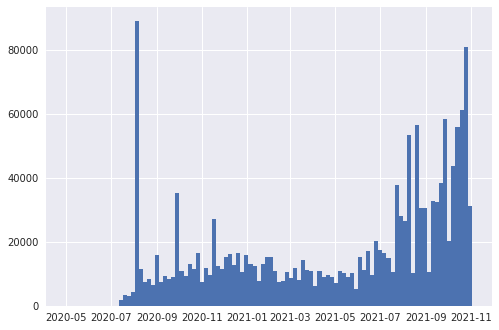

In [6]:
prod_df["created_date"].hist(bins=100)

In [7]:
prod_df["last_checked_date"].value_counts().sort_index().tail(10)

2021-10-24       1461
2021-10-25       2032
2021-10-26       2189
2021-10-27    1218307
2021-10-28      12865
2021-10-29       6942
2021-10-30       6888
2021-10-31       6098
2021-11-01       6751
2021-11-02       1184
Name: last_checked_date, dtype: int64

In [8]:
last_batch_date = pd.to_datetime("2021-10-27")
prod_df_new = prod_df[prod_df.created_date > last_batch_date]

In [9]:
prod_df_new.shape

(31053, 57)

<AxesSubplot:>

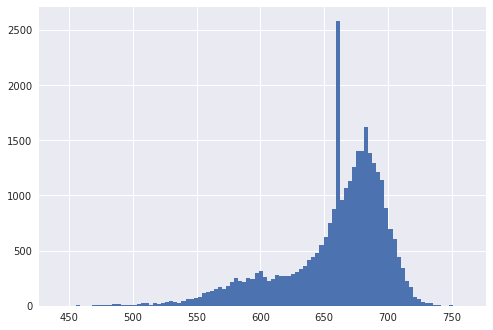

In [10]:
prod_df_new["model_score"].hist(bins=100)

In [11]:
troubled_fts = ["first_deposit_amount",
       "transaction_as_pct_of_balance",
       "lag_acc_open_first_transaction",
       "mean_account_balance_30d",
       "nr_past_transactions",
       "time_since_last_transaction",
       "credit_card_loan_amount"]
prod_df_new[troubled_fts]

,first_deposit_amount,transaction_as_pct_of_balance,lag_acc_open_first_transaction,mean_account_balance_30d,nr_past_transactions,time_since_last_transaction,credit_card_loan_amount
167,-1.0,0.0,-1.0,0.0,-1.0,-1.0,4400.0
185,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0
195,-1.0,0.0,-1.0,0.0,-1.0,-1.0,129764.0
197,-1.0,0.0,-1.0,0.0,-1.0,-1.0,37712.0
219,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1195.0
...,...,...,...,...,...,...,...
1596146,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0
1596147,-1.0,0.0,-1.0,0.0,-1.0,-1.0,13417.0
1596148,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0
1596149,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0


In [12]:
prod_df_new.request_source.value_counts()

"onboarding"    30468
"tenure"          465
"return"          120
Name: request_source, dtype: int64

In [16]:
# prod_df_new[prod_df_new[f] > -1]

In [18]:
# for f in troubled_fts:
#     df_ = prod_df_new[prod_df_new.request_source=='"onboarding"'][f]
#     df_.hist(bins=100, alpha=0.4, label=f)
#     plt.legend()
#     plt.show()
#     display(df_.value_counts().head())

In [19]:
prod_df_new[prod_df_new.request_source=='"onboarding"'].shape

(30468, 57)

In [20]:
default_values = {
    'transaction_as_pct_of_balance': 0,
    'max_withdrawals_30d': 0,
    'max_deposits_30d': 0,
    'pct_returned_deposits': 0,
    'bal_ratio': 0,
    'sum_deposits_10d': 0,
    'mean_account_balance_30d': 0,
    'dollar_val_dd': 0,
    'nr_direct_deposits': 0,
    'nr_past_transactions': -1,  # -1 is the default in production where we have 0 in dev...
    'dollar_val_returns': 0,
    'dollar_val_returns_3d': 0,
    'nr_returns_30d': 0,
    'time_since_last_transaction': -1,
#     'giact_nr_decline': -1,
#     'giact_nr_other': -1,
    'nr_trans_ratio': -1,
    'first_deposit_amount': -1,
    'lag_acc_open_first_transaction': -1,
    'transaction_code_encoded': 0,  
}

In [21]:
vcs = {}
for f in default_values:
     vcs[f] = (prod_df_new[f] == default_values[f]).value_counts()

In [22]:
is_default_df = pd.concat(vcs).unstack()
is_default_df["pct_default"] = is_default_df[True] / (is_default_df[False] + is_default_df[True])

In [23]:
tfts = ['transaction_as_pct_of_balance',
     'time_since_last_transaction',
     'nr_past_transactions',
     'pct_returned_deposits',
     'dollar_val_returns',
     'dollar_val_returns_3d',
     'mean_account_balance_30d',
     'sum_deposits_10d',
     'max_deposits_30d',
     'max_withdrawals_30d',
     'nr_direct_deposits',
     'bal_ratio',
     'dollar_val_dd',
     'nr_returns_30d',
     'nr_trans_ratio',
     'transaction_code_encoded'
]

In [24]:
is_default_df.loc[tfts]

,True,False,pct_default
transaction_as_pct_of_balance,30614,439,0.985863
time_since_last_transaction,30560,493,0.984124
nr_past_transactions,30440,613,0.980260
pct_returned_deposits,31003,50,0.998390
dollar_val_returns,31003,50,0.998390
dollar_val_returns_3d,31014,39,0.998744
mean_account_balance_30d,30596,457,0.985283
sum_deposits_10d,30765,288,0.990726
max_deposits_30d,30762,291,0.990629
max_withdrawals_30d,30727,326,0.989502


In [25]:
vcs_all = prod_df_new[dkeys].value_counts().rename("counts").to_frame().reset_index()
vcs_all["max"] = vcs_all["counts"] == vcs_all["counts"].max()

NameError: name 'dkeys' is not defined

In [26]:
max_vals = vcs_all[vcs_all["max"]].T.to_dict()[0]
for k in default_values:
    assert(max_vals[k] == default_values[k])

NameError: name 'vcs_all' is not defined

In [27]:
vcs_all["pct"] = vcs_all["counts"] / vcs_all["counts"].sum()

NameError: name 'vcs_all' is not defined

In [28]:
vcs_all  # 97.9% of the onboading accounts has missing for all its transactions features missing

NameError: name 'vcs_all' is not defined

In [197]:
prod_df_new["updated_dt"].value_counts(dropna=False)

NaN                        19650
2021-10-28 18:04:45.330        2
2021-11-01 00:10:29.176        1
2021-11-01 17:38:44.978        1
2021-11-01 18:49:47.320        1
                           ...  
2021-10-28 17:57:33.853        1
2021-10-30 11:48:15.380        1
2021-10-28 19:50:06.228        1
2021-10-28 21:08:17.770        1
2021-11-02 01:58:26.658        1
Name: updated_dt, Length: 11403, dtype: int64

In [198]:
prod_df_new["has_updated"] = ~prod_df_new["updated_dt"].isna()

In [201]:
prod_df_new[prod_df_new["has_updated"]].head()[["created_dt", "updated_dt"]]

,created_dt,updated_dt
361,2021-10-28 15:37:13.614,2021-10-28 19:33:26.233
1106,2021-10-28 13:50:32.993,2021-10-28 13:51:00.630
1647,2021-10-28 14:16:39.621,2021-10-28 14:17:36.439
1863,2021-10-28 01:47:56.187,2021-10-28 01:48:49.928
2013,2021-10-28 03:02:37.658,2021-10-28 03:03:01.159


In [205]:
prod_df_new[prod_df_new["has_updated"]].head()[tfts]

,transaction_as_pct_of_balance,time_since_last_transaction,nr_past_transactions,pct_returned_deposits,dollar_val_returns,dollar_val_returns_3d,mean_account_balance_30d,sum_deposits_10d,max_deposits_30d,max_withdrawals_30d,nr_direct_deposits,bal_ratio,dollar_val_dd,nr_returns_30d,nr_trans_ratio,transaction_code_encoded
361,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
1106,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
1647,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
1863,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
2013,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0


In [209]:
from collections import defaultdict

tcode_map = defaultdict(int,
                        {'POSDW': 1,
                         'ACHDD': 2,
                         'ACHDWIN': 3,
                         'ACHDDIN': 4,
                         'ACHDW': 5,
                         'ACHINDD': 6,
                         'DDATMREFUND': 7,
                         'DWATM': 8,
                         'DDRAFNEW':9,
                         'DDCK': 10})


In [207]:
prod_df_new[prod_df_new.transaction_code_encoded != 0]

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date,has_updated
294,3257371,2021-11-01 04:32:27.786,None,2021-11-01,2021-11-01 04:32:27.782,"""RG1""","""tenure""",510.569178,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,2.0,NaN,1.0,36894.0,1,-1.0,-1.0,2021-11-01,False
6423,2398759,2021-11-01 06:31:14.838,None,2021-11-01,2021-11-01 06:31:14.834,"""RG3A""","""return""",528.214475,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG3A""",...,0.0,0.0,NaN,0.0,0.0,1,996.0,996.0,2021-11-01,False
10013,13330676,2021-10-30 04:31:33.887,None,2021-10-30,2021-10-30 04:31:33.881,"""RG4A""","""tenure""",579.940852,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4A""",...,0.0,0.0,NaN,0.0,2350.0,1,-1.0,-1.0,2021-10-30,False
10617,10713912,2021-11-01 04:32:23.998,None,2021-11-01,2021-11-01 04:32:23.994,"""RG4B""","""tenure""",591.905323,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,69763.0,0.0,6174.0,0.0,515.0,4,-1.0,-1.0,2021-11-01,False
13065,11306002,2021-11-01 04:32:09.623,None,2021-11-01,2021-11-01 04:32:09.619,"""RG1""","""tenure""",507.205478,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,1.0,20935.0,1.0,977.0,5,-1.0,-1.0,2021-11-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574255,20663735,2021-10-28 12:33:26.672,2021-11-01 06:31:13.634,2021-11-01,2021-11-01 06:31:13.632,"""RG5""","""return""",680.911926,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,0.0,NaN,0.0,0.0,2,-1.0,997.0,2021-10-28,True
1584068,20540941,2021-10-28 10:46:42.798,None,2021-10-28,2021-10-28 10:46:42.793,"""RG4B""","""return""",591.035399,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,0.0,0.0,NaN,0.0,9.0,1,-1.0,-1.0,2021-10-28,False
1586096,20674076,2021-10-28 23:42:48.728,2021-11-01 21:01:12.784,2021-11-01,2021-11-01 21:01:12.782,"""RG4B""","""return""",588.856262,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,0.0,0.0,34189.0,0.0,7262.0,2,-1.0,-1.0,2021-10-28,True
1589265,19893844,2021-11-01 04:32:22.228,None,2021-11-01,2021-11-01 04:32:22.225,"""RG4A""","""tenure""",569.225914,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4A""",...,0.0,0.0,8678.0,0.0,2117.0,1,-1.0,-1.0,2021-11-01,False


In [206]:
vcs_all

,transaction_as_pct_of_balance,max_withdrawals_30d,max_deposits_30d,pct_returned_deposits,bal_ratio,sum_deposits_10d,mean_account_balance_30d,dollar_val_dd,nr_direct_deposits,nr_past_transactions,...,time_since_last_transaction,giact_nr_decline,giact_nr_other,nr_trans_ratio,first_deposit_amount,lag_acc_open_first_transaction,transaction_code_encoded,counts,max,pct
0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,-1.0,...,-1.0,0.0,0.0,-1.000000,-1.0,-1.0,0,30411,True,0.979326
1,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,-1.0,...,-1.0,0.0,1.0,-1.000000,-1.0,-1.0,0,20,False,0.000644
2,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,...,-1.0,0.0,0.0,1.000000,-1.0,-1.0,0,20,False,0.000644
3,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,...,-1.0,0.0,0.0,-1.000000,-1.0,-1.0,0,19,False,0.000612
4,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,...,-1.0,0.0,0.0,0.000000,-1.0,-1.0,0,18,False,0.000580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.402188,-875.70,1800.0,0.0,0.126997,15.45,1103.503205,254.64,2.0,103.0,...,0.0,0.0,0.0,0.077922,10.0,0.0,1,1,False,0.000032
531,-0.410928,-9.25,0.0,0.0,0.600748,0.00,22.072500,0.00,0.0,5.0,...,6.0,0.0,0.0,0.333333,10.0,0.0,1,1,False,0.000032
532,-0.419986,0.00,0.0,0.0,1.000000,0.00,40.050000,0.00,0.0,5.0,...,9.0,0.0,1.0,-1.000000,500.0,1.0,3,1,False,0.000032
533,-0.421575,-1500.00,2633.0,0.0,0.673005,0.00,3058.060000,0.00,0.0,7.0,...,25.0,0.0,1.0,0.500000,10.0,1.0,5,1,False,0.000032


In [210]:
prod_df_new.shape

(31053, 58)

In [218]:
df_ = vcs_all.groupby("max").counts.sum()
df_.index.rename("default_trnx_fts", inplace=True)
display(df_)

default_trnx_fts
False      642
True     30411
Name: counts, dtype: int64

<AxesSubplot:>

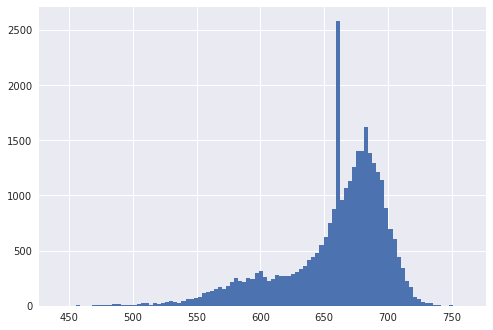

In [226]:
prod_df_new.model_score.hist(bins=100)

In [256]:
from src.monitoring.utils import preprocess, scale_scores

prod_df_new_default = prod_df_new.copy(deep=True)
for f in default_values:
    print(f)
    prod_df_new_default[f] = default_values[f]
prod_df_new_default = preprocess(prod_df_new_default)

transaction_as_pct_of_balance
max_withdrawals_30d
max_deposits_30d
pct_returned_deposits
bal_ratio
sum_deposits_10d
mean_account_balance_30d
dollar_val_dd
nr_direct_deposits
nr_past_transactions
dollar_val_returns
dollar_val_returns_3d
nr_returns_30d
time_since_last_transaction
nr_trans_ratio
first_deposit_amount
lag_acc_open_first_transaction
transaction_code_encoded


In [257]:
import pickle as pkl
from smart_open import open

incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)

In [258]:
prod_df_new["model_score_w_default"] = incumbent_model.predict_proba(prod_df_new_default[incumbent_model.feature_name_])[:,1]
prod_df_new["model_score_w_default"] = scale_scores(prod_df_new["model_score_w_default"])

<AxesSubplot:>

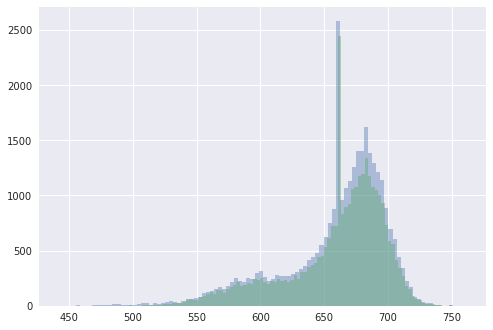

In [259]:
prod_df_new["model_score"].hist(bins=100, alpha=0.4)
prod_df_new["model_score_w_default"].hist(bins=100, alpha=0.4)

In [260]:
diff = prod_df_new["model_score"]-prod_df_new["model_score_w_default"]
diff.describe(percentiles=[0.01, 0.02, 0.98, 0.99]).round(2)

count    31053.00
mean        -0.82
std          7.87
min       -134.84
1%         -41.75
2%          -0.00
50%          0.00
98%          0.00
99%          0.00
max         99.87
dtype: float64

<AxesSubplot:>

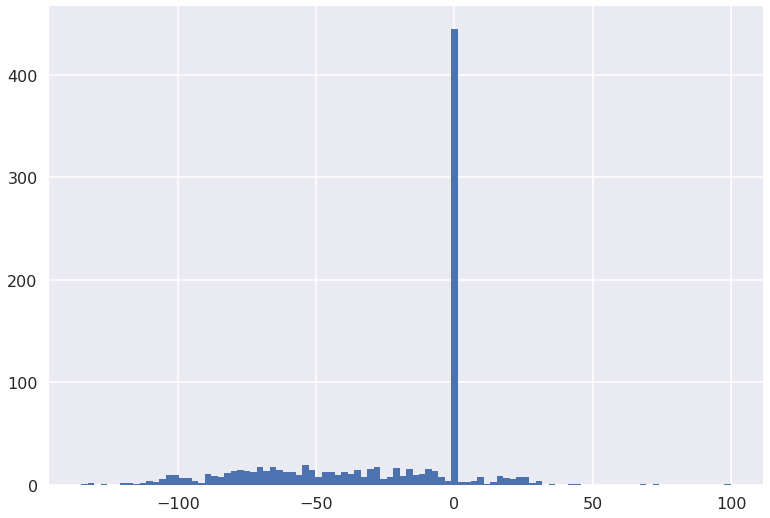

In [265]:
diff[diff!=0].hist(bins=100)

In [254]:
(diff == 0).value_counts()

True     30044
False     1009
dtype: int64

In [266]:
diff[diff!=0].value_counts().

-1.136868e-13    232
 1.136868e-13    206
 1.718965e+01      5
 5.684342e-14      4
-5.849190e+00      3
                ... 
-5.331338e+01      1
-5.652046e+01      1
-1.082323e+02      1
 9.273882e+00      1
 2.442708e+01      1
Length: 564, dtype: int64

In [270]:
(diff.between(-1e-6, 1e-6)).value_counts()

True     30486
False      567
dtype: int64

In [271]:
dc = (diff.between(-1e-6, 1e-6)).value_counts()
dc /= dc.sum()
dc

True     0.981741
False    0.018259
dtype: float64

#### check profile data update cadence

In [219]:
cols = ["created_dt", "business_account_number", "transaction_amount"]
tdf = pd.read_feather("../../data/processed/processed_1634519596/transactions_1634519596.feather", columns=cols)

In [220]:
tdf.shape

(54043457, 3)

In [221]:
# plot created_dt spacing
tdf.head()

,created_dt,business_account_number,transaction_amount
0,2021-06-24,310000101015,5.0
1,2021-07-23,310000101015,5.0
2,2021-08-01,310000101015,0.0
3,2021-09-01,310000101015,0.0
4,2021-10-01,310000101015,0.0


In [223]:
tdf["created_date"] = pd.to_datetime(tdf["created_dt"])

In [224]:
tdf["created_date"].value_counts().sort_index()

2017-12-13         1
2017-12-19         6
2017-12-20        19
2017-12-21         4
2017-12-22        10
               ...  
2021-10-13    163268
2021-10-14    145125
2021-10-15    144714
2021-10-16     98501
2021-10-17      1418
Name: created_date, Length: 1386, dtype: int64